## **MULTIMODAL-LEARNING: is there a way to combine both the textual data with the numerical and categorical data?**

# Introduction

In this notebook you will find two methods for incorporating tabular data (numerical and categorical) with textual data before training.

The first method involves transforming the tabular data into textual data through preprocessing, then combining these new textual features with the text already present in the dataset, then fine-tune a pre-trained transformer-based model. For example, if you have the numerical variable "Age", you will transform it into the following textual variable: "I am [Age] years."

The second method corresponds to an Early-Middle fusion model. We fine-tune a pre-trained transformer-based model on the textual data, then concatenate the "[CLS]" token output of the last hidden layer with the tabular data before applying a classifier to the concatenation.

# Setup

## Installation


We install several packages used subsequently used

In [ ]:
!pip install -q transformers datasets xgboost torch

##Data

The data comes from the Hugging Face Hub :
https://huggingface.co/datasets/arize-ai/ecommerce_reviews_with_language_drift

It consists on an e-commerce product review dataset. Some other features have been added (age, gender, category of the product) and so the dataset aligns with our objective in terms of features.

for this example, we decided:

1. to subsample the data to make all processing and training faster 

2. to change the taxonomy by removing a neutral reviews to have a binary classification problem

3. to remove the variable ```language``` which is a constant equal to  ```english```. Nevertheless this information is important to chose the adéquat pre-trained model checkpoint


In [ ]:
from datasets import load_dataset, dataset_dict, DatasetDict, Dataset, ClassLabel

In [ ]:
#Dataset used
dataset_name = 'arize-ai/ecommerce_reviews_with_language_drift'

#Load the data on the Hugging Face Hub
dataset = load_dataset(dataset_name) 

#We split the dataset into a train, test and validation set:
#90% train 
#10% test
#10% validation

train_test_dataset = dataset["training"].train_test_split(test_size=0.2)
test_valid = train_test_dataset['test'].train_test_split(test_size=0.5)

train_test_val_dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid['test'],
    'val': test_valid['train']})


  0%|          | 0/3 [00:00<?, ?it/s]

### Sample

In [ ]:
train_test_val_dataset['train'][0]

{'prediction_ts': 1650780416.0,
 'reviewer_age': 27,
 'reviewer_gender': 'male',
 'product_category': 'apparel',
 'language': 'english',
 'text': 'I brought an XXL (I am a size 16) because I thought this dress ran small. It actually runs as expected because I had to return the XXL and re-order the XL. The dress fits beautifully and I love it.',
 'label': 2}

### Statistics

We compute some statistics to have a better understanding of our data and anticipate some preprocessing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


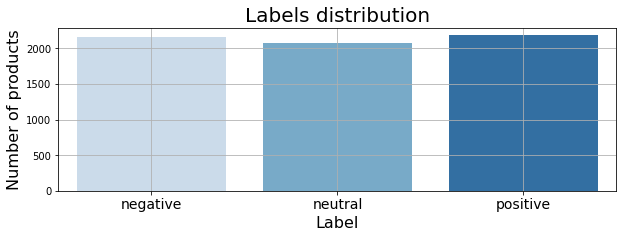

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


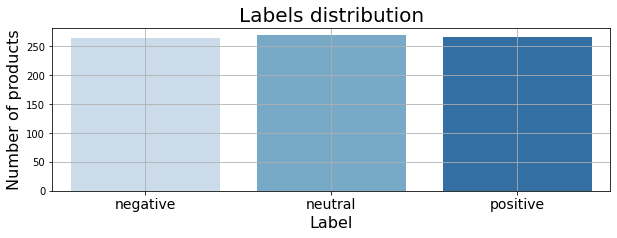

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


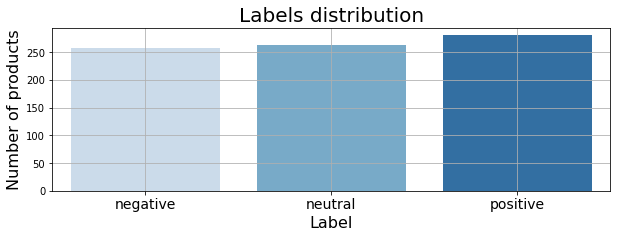

In [ ]:
#We plot and check the label distribution to avoid any unbalanced issue 
for i in train_test_val_dataset.keys():
  all_labels = list(train_test_val_dataset[i].to_pandas().label.values)
  labels_counts = Counter(all_labels).most_common()
  labels_counts = sorted(labels_counts, key=lambda x: x[0])
  labels, labels_counts = zip(*labels_counts)
  plt.figure(figsize=(10,3))
  ax = sns.barplot(list(labels), list(labels_counts), palette='Blues')
  plt.title("Labels distribution", fontsize=20)
  plt.xlabel("Label", fontsize=16)
  ax.set_xticklabels(['negative', 'neutral', 'positive'], rotation=0, fontsize=14)
  plt.ylabel("Number of products", fontsize=16)
  plt.grid(visible=True)
  plt.show()

As we want to set up a binary classification problem, we change the taxonomy by removing the "neutral" label.

In [ ]:
train_df = train_test_val_dataset['train'].to_pandas()
val_df = train_test_val_dataset['val'].to_pandas()
test_df = train_test_val_dataset['test'].to_pandas()

train_df = train_df[train_df.label != 1]
val_df = val_df[val_df.label != 1]
test_df = test_df[test_df.label != 1]

for df in [train_df, val_df, test_df]:
    df['label'] = df['label'].replace(2, 1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


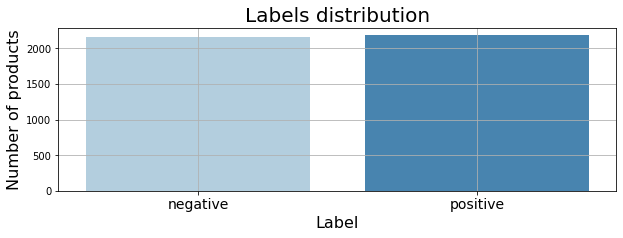

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


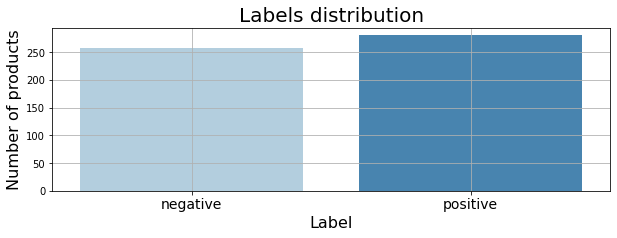

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


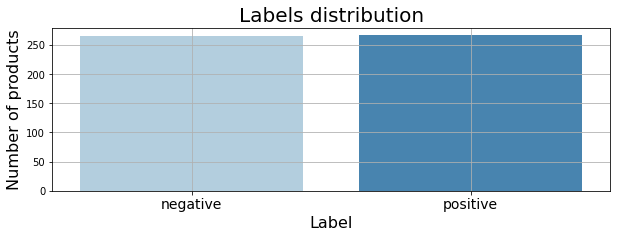

In [ ]:
for df in [train_df, val_df, test_df]:
    all_labels = list(df.label.values)
    labels_counts = Counter(all_labels).most_common()
    labels_counts = sorted(labels_counts, key=lambda x: x[0])
    labels, labels_counts = zip(*labels_counts)
    plt.figure(figsize=(10,3))
    ax = sns.barplot(list(labels), list(labels_counts), palette='Blues')
    plt.title("Labels distribution", fontsize=20)
    plt.xlabel("Label", fontsize=16)
    ax.set_xticklabels(['negative', 'positive'], rotation=0, fontsize=14)
    plt.ylabel("Number of products", fontsize=16)
    plt.grid(visible=True)
    plt.show()

We see that we have a well balanced datasets.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


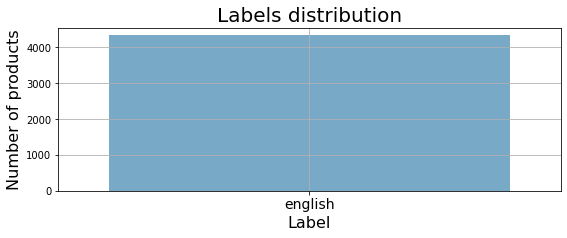

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


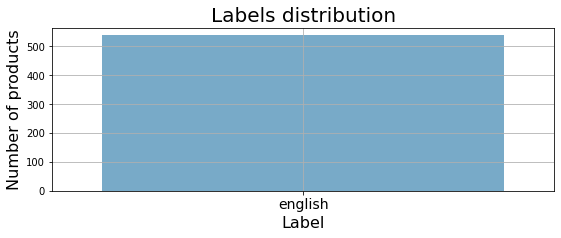

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


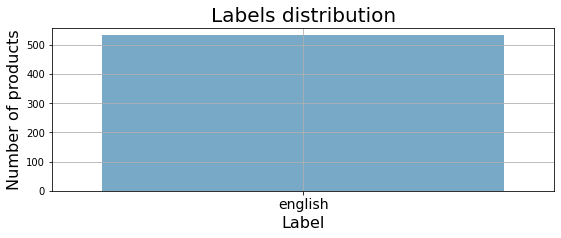

In [ ]:
for df in [train_df, val_df, test_df]:
    all_labels = list(df.language.values)
    labels_counts = Counter(all_labels).most_common()
    labels_counts = sorted(labels_counts, key=lambda x: x[0])
    labels, labels_counts = zip(*labels_counts)
    plt.figure(figsize=(9,3))
    ax = sns.barplot(list(labels), list(labels_counts),palette="Blues")
    plt.title("Labels distribution", fontsize=20)
    plt.xlabel("Label", fontsize=16)
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    plt.ylabel("Number of products", fontsize=16)
    plt.grid(visible=True)
    plt.show()


Since there is only one value for the language variable, we will not consider it in the different trainings, but we will take note of it when choosing the appropriate pre-trained model.

#Models using distinct features

To maintain consistency, we re-apply the different unimodal methods.
Firstly, we train an XGBoost on the numerical and categorical data, and then fine-tune a pre-trained Bert model on the textual variable (customer's reviews).

## Model 1: XGBoost with tabular data

We train a XGBoost on the numerical and categorical features

### Preprocessing

In [ ]:
# We change the types of all features to match with the use of a XGboost
X_train = train_df.copy()
X_validation = val_df.copy()
X_test = test_df.copy()

# for each sub dataset we change the reviewer_age in interger and the reviewer_gender and the product_category as a category variable
for df in [X_train, X_validation, X_test]:
  df["reviewer_age"] = df["reviewer_age"].astype('int')
  df["reviewer_gender"] = df["reviewer_gender"].astype('category')
  df["product_category"] = df["product_category"].astype('category')

  df["reviewer_gender"] = df["reviewer_gender"].cat.codes
  df["product_category"] = df["product_category"].cat.codes

X_train = X_train[['reviewer_age','reviewer_gender', 'product_category']]
X_validation = X_validation[['reviewer_age','reviewer_gender', 'product_category']]
X_test = X_test[['reviewer_age','reviewer_gender', 'product_category']]
      
y_train = train_df['label'].astype('category')
y_val = val_df['label'].astype('category')
y_test = test_df['label'].astype('category')

### Training & Prediction

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
# Create an instance of the XGBoost classifier
tabular_model = XGBClassifier(objective='binary:logistic', seed=42)

#Train it on the train set.
tabular_model.fit(X_train, y_train)

#Use the trained model to predict the labels for the test set.
predictions = tabular_model.predict(X_test)

#We compute the F1 score and the Accuracy as metrics of our problem.
f1 = f1_score(y_true = y_test, y_pred = predictions)
accuracy = accuracy_score(y_test, predictions)

result = {'Model': 'XGBoost', 
          'F1': f1, 
          'Accuracy': accuracy}
          
df_result = pd.DataFrame([result])

print(df_result)

     Model        F1  Accuracy
0  XGBoost  0.583026  0.574388


We obtain vanilla results that perform slightly better than random.

### Statistics

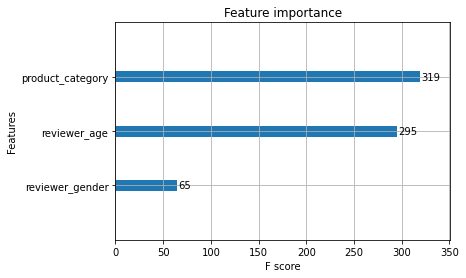

In [ ]:
#Plot feature importance
#This can help to understand which features are driving the predictions of the model and identify any redundant or irrelevant features.
plot_importance(tabular_model)
plt.show()

The `reviewer_gender` variable does not appear to be having a strong impact on the model's predictions, which is not surprising as the variable is simply a binary indicator of gender. However, we can conclude that there is no gender bias present in our dataset.

## Model 2: Bert with ```review``` only
We fine-tune a pre-trained Bert model on the English language using the ```text``` variable corresponding to the custumer's reviews.

The choice of BERT as a pre-trained model is due to its popularity and efficiency in the NLP community. BERT is a good starting point and it is well-known and widely used, but it is not the only option available, and there are other models that might be better suited for classification tasks, resource-constrained environments, and specific data.

### Preprocessing

In [ ]:
tds = Dataset.from_pandas(train_df)
vds = Dataset.from_pandas(val_df)
pds = Dataset.from_pandas(test_df)

#We gather the train, test and val sets in a dict
ds = DatasetDict()

ds['train'] = tds
ds['val'] = vds
ds['test'] = pds

for t in ['train', 'val', 'test']:
  new_features = ds[t].features.copy()
  new_features["label"] = ClassLabel(names=["negative", "positive"])
  ds[t] = ds[t].cast(new_features)

Casting the dataset:   0%|          | 0/5 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

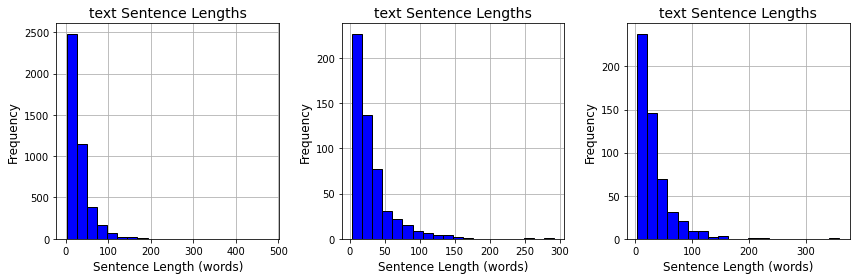

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, c in enumerate([train_df, val_df, test_df]):
    sentence_lengths = c.text.apply(lambda x: len(x.split()))
    axs[i].hist(sentence_lengths, bins=20, color='blue', edgecolor='black')
    axs[i].set_xlabel('Sentence Length (words)', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
    axs[i].set_title(f'{c.text.name} Sentence Lengths', fontsize=14)
    axs[i].grid(visible=True)
    axs[i].set_axisbelow(True)

plt.tight_layout()
plt.show()


We see that the majority of reviews are shorter than around 128 words. So, for computational reasons and without losing too much information, we decided to fix the maximum input size to 128, which is also a common value used in the literature.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [ ]:
#The pre-trained model we finetune (https://huggingface.co/bert-base-uncased)
model_checkpoint = "bert-base-uncased" 

# Load the Bert tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

def tokenize(sample, variable='text', tab_data=None):

    #We truncate the reviews longer than 128 and padd according the max_length in a batch
    encoding = bert_tokenizer(sample[variable], padding=True, max_length=128, truncation=True) 

    #If we set tab_data, we concatenate all 1-dimensional non-textual data
    if tab_data:   
      encoding['extra_data'] = list(zip(sample['reviewer_age'], sample['reviewer_gender'], sample['product_category']))

    return encoding

#We encode our all dataset
tokenized_datasets = ds.map(tokenize,                         #Tokenizer we use
                            fn_kwargs={"variable": 'text'},   #The variable we tokenize
                            batched=True,                     #Operate on batches
                            remove_columns=['prediction_ts', 	#Variables we remove for next steps
                                            'reviewer_age',
                                            'reviewer_gender',
                                            'product_category',
                                            'language',
                                            '__index_level_0__'
                                            ])

#According the Hugging Face doc, we have to set up the name of the varibale ("labels" not "label")
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

#We convert our inputs into tensors.
tokenized_datasets.set_format("torch") 

#What our dataset looks like
print(tokenized_datasets)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4332
    })
    val: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 537
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 531
    })
})


We compute performance metrics during the training process. To do this, we have to define a "compute_metrics" function that returns a dictionary containing the desired metric values.


In [ ]:
from datasets import load_metric

#We define a metric function used during the training.
#We calculate the argmax of the logit vector to compute the F1 score and the Accuracy score
def compute_metrics(eval_pred):
    metric1 = load_metric("accuracy")
    metric2 = load_metric("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = metric2.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1, "accuracy": accuracy}

In [ ]:
#We call our pre-trained Bert model
bert_model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

#To achieve rapid and satisfactory results, we freeze all the Bert weights fixed and train only a classifier on top of the pre-trained BERT model
for param in bert_model.bert.parameters(): 
    param.requires_grad = False

#We check if our freeze call works, we display layers that will be trained 
for name, param in bert_model.named_parameters():
     if param.requires_grad==True:
      print(name, param.requires_grad)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

classifier.weight True
classifier.bias True


In [ ]:
#We check if we have a GPU to make our trainings faster
#We don't need to define a "device" variable as the Trainer API will handle it for us
#Using Colab give us the option to use 1 GPU ("Tesla T4")

if torch.cuda.is_available():       
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
Device name: Tesla T4


### Training

We train all following models using HuggingFace's Trainer API.

We need to define:

-`TrainingArguments` which setups training hyperparameters. 

-`Trainer` defines the model, training and validation data, metrics, and saving method used during the training process.

We train for 3 epochs using a batch size of 8 samples with a evaluation method using also an `EarlyStoppingCallback` function to make our training eventually faster and avoid overfitting.
We evaluate after every epochs and save the best model and the last model of the training.


In [ ]:
from transformers import (TrainingArguments, Trainer, 
                          EarlyStoppingCallback, IntervalStrategy,
                          default_data_collator)

In [ ]:
batch_size = 8                          #batch size
nb_epochs = 9                           #number of epochs
learning_rate = 2e-5                    #learning rate
data_collator = default_data_collator   #data_collator


#The CrossEntropyLoss() and the optimizer are chosen according to the problem setup in the Trainer API

args = TrainingArguments(
    output_dir="model_bert_review",                                             # our trained model is saved in the file "...\model_bert_review" 
    evaluation_strategy = IntervalStrategy.EPOCH,                               # evalation happens after each epoch
    save_strategy = IntervalStrategy.EPOCH,                                     # save happends after each epoch
    save_total_limit = 2,                                                       # number maximal of models we can save
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=nb_epochs,
    metric_for_best_model = 'accuracy',                                         # best model selection according to the Accuracy
    load_best_model_at_end=True,                                                # to load the best model after training
    seed=0,
)

trainer_review_only = Trainer(
    model=bert_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics,                                            # metrics used
    data_collator = data_collator,                                              # batch our data
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)]              # early stopping configuration
)

trainer_review_only.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4332
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4878
  Number of trainable parameters = 1538


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.692800,0.684299,0.662791,0.567970
2,0.681600,0.672726,0.695266,0.616387
3,0.671500,0.663728,0.737342,0.690875
4,0.664100,0.656844,0.760000,0.731844
5,0.661200,0.651304,0.774584,0.722533
6,0.653300,0.647605,0.780069,0.761639
7,0.648400,0.644680,0.786777,0.759777
8,0.647500,0.643038,0.785953,0.761639
9,0.643500,0.642519,0.789744,0.770950


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 537
  Batch size = 8
<ipython-input-18-cdf6d05a425b>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("accuracy")
Saving model checkpoint to model_bert_review/checkpoint-542
Configuration saved in model_bert_review/checkpoint-542/config.json
Model weights saved in model_bert_review/checkpoint-542/pytorch_model.bin
Deleting older checkpoint [model_bert_review/checkpoint-3745] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificat

TrainOutput(global_step=4878, training_loss=0.66131057520292, metrics={'train_runtime': 353.5172, 'train_samples_per_second': 110.286, 'train_steps_per_second': 13.798, 'total_flos': 2564543456593920.0, 'train_loss': 0.66131057520292, 'epoch': 9.0})

### Prediction

In [ ]:
predictions = trainer_review_only.predict(tokenized_datasets["test"])
new_result = {'Model': 'BERT_review_only', 'F1': predictions.metrics['test_f1'], 'Accuracy': predictions.metrics['test_accuracy']}
df2 = pd.DataFrame([new_result])
df_result = pd.concat([df_result, df2], ignore_index=True)
df_result

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 531
  Batch size = 8


,Model,F1,Accuracy
0,XGBoost,0.583026,0.574388
1,BERT_review_only,0.805508,0.787194


Like we could expect, we obtained better results traning on the text than training on the tabular data by using a XGBoost model.

# Models using all features

We are testing two approaches to outperform the results obtained using only the text variable on one side and using only the tabular data on the other side:

- Finetune pre-trained BERT model on the all features concatened as textual modality to do the classification

- Train a classifier on the concatenation of the [CLS] token of the last hidden state of a pre-trained BERT model, fine-tuned on the `review` variable, and the tabular data as one multi-dimensional vector.

## Model 3: Bert with all textual features

We finetune a Bert model on the concatenated of all variables transform as textual data.
In order to compare well our outputs metrics, we set the same hyperparameters for all trainings.

### Preprocessing

In [ ]:
#We change tabular data into sentence
print(train_df.isnull().values.any()) #no NaN

def tab_to_text(row): 
    '''
    We transform our tabular into textual data by creating sentences combining all variables.
    '''
    combined = ""
    combined += "I am {:d} years {:}. ".format(int(row["reviewer_age"]), row["reviewer_gender"])
    combined += "The product is from {:} category. ".format(row["product_category"])
    combined += row["text"]
    return combined

for df in [train_df, val_df, test_df]:
  df['all_text'] = df.apply(lambda row : tab_to_text(row), axis = 1)

tds_2 = Dataset.from_pandas(train_df)
vds_2 = Dataset.from_pandas(val_df)
pds_2 = Dataset.from_pandas(test_df)

ds_2 = DatasetDict()

ds_2['train'] = tds_2
ds_2['val'] = vds_2
ds_2['test'] = pds_2

for t in ['train', 'val', 'test']:
  new_features = ds_2[t].features.copy()
  new_features["label"] = ClassLabel(names=["negative", "positive"])
  ds_2[t] = ds_2[t].cast(new_features)

False


Casting the dataset:   0%|          | 0/5 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
#We use the same Bert tokenizer but applied to the new varibale
one_text_tokenized_datasets = ds_2.map(tokenize, 
                                       fn_kwargs={"variable": 'all_text'},
                                       batched=True, 
                                       remove_columns=['prediction_ts',
                                                      'reviewer_age',
                                                      'reviewer_gender',
                                                      'product_category',
                                                      'language',
                                                      '__index_level_0__',
                                                      'text',
                                                      'all_text'])

one_text_tokenized_datasets = one_text_tokenized_datasets.rename_column("label", "labels")

one_text_tokenized_datasets.set_format("torch")


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
bert_model_tab_to_text = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

for param in bert_model_tab_to_text.bert.parameters():
    param.requires_grad = False

for name, param in bert_model_tab_to_text.named_parameters():
     if param.requires_grad:
      print(name, param.requires_grad)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

classifier.weight True
classifier.bias True


### Training

In [ ]:
args = TrainingArguments(
    output_dir="model_bert_all_text",
    evaluation_strategy = IntervalStrategy.EPOCH,
    save_strategy = IntervalStrategy.EPOCH,
    save_total_limit = 2,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=nb_epochs,
    metric_for_best_model = 'accuracy',
    load_best_model_at_end=True,
    seed=0,
)

trainer_bert_all_text = Trainer(
    model=bert_model_tab_to_text,
    args=args,
    train_dataset=one_text_tokenized_datasets["train"],
    eval_dataset=one_text_tokenized_datasets["val"],
    compute_metrics=compute_metrics,
    data_collator = data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_bert_all_text.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4332
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4878
  Number of trainable parameters = 1538


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.693800,0.682029,0.692199,0.595903
2,0.681700,0.671500,0.757813,0.769088
3,0.674100,0.662149,0.785965,0.772812
4,0.664800,0.655596,0.764706,0.776536
5,0.664600,0.649776,0.787456,0.772812
6,0.653200,0.646287,0.772727,0.776536
7,0.654100,0.643133,0.795139,0.780261
8,0.648800,0.641716,0.795699,0.787709
9,0.649700,0.641198,0.788427,0.782123


***** Running Evaluation *****
  Num examples = 537
  Batch size = 8
Saving model checkpoint to model_bert_all_text/checkpoint-542
Configuration saved in model_bert_all_text/checkpoint-542/config.json
Model weights saved in model_bert_all_text/checkpoint-542/pytorch_model.bin
Deleting older checkpoint [model_bert_all_text/checkpoint-4280] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 537
  Batch size = 8
Saving model checkpoint to model_bert_all_text/checkpoint-1084
Configuration saved in model_bert_all_text/checkpoint-1084/config.json
Model weights saved in model_bert_all_text/checkpoint-1084/pytorch_model.bin
Deleting older checkpoint [model_bert_all_text/checkpoint-4815] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 537
  Batch size = 8
Saving model checkpoint to model_bert_all_text/checkpoint-1626
Configuration saved in model_bert_all_text/checkpoint-1626/config.json
Model weights saved in model_bert_all_text/checkpoint-

TrainOutput(global_step=4878, training_loss=0.6637965941732171, metrics={'train_runtime': 361.2988, 'train_samples_per_second': 107.911, 'train_steps_per_second': 13.501, 'total_flos': 2564543456593920.0, 'train_loss': 0.6637965941732171, 'epoch': 9.0})

### Prediction

In [ ]:
predictions = trainer_bert_all_text.predict(one_text_tokenized_datasets["test"])
new_result = {'Model': 'Bert_all_text', 'F1': predictions.metrics['test_f1'], 'Accuracy': predictions.metrics['test_accuracy']}
df2 = pd.DataFrame([new_result])
df_result = pd.concat([df_result, df2], ignore_index=True)
df_result

***** Running Prediction *****
  Num examples = 531
  Batch size = 8


,Model,F1,Accuracy
0,XGBoost,0.583026,0.574388
1,BERT_review_only,0.805508,0.787194
2,Bert_all_text,0.820976,0.813559


We obtain better results than the two independant previous models.

## Model 4: BertTabular 

A classifier is trained on the concatenation of tabular data and the [CLS] token output of the last hidden state of a BERT model that is specifically trained on ```review``` variable."


*image source: https://github.com/georgian-io/Multimodal-Toolkit*

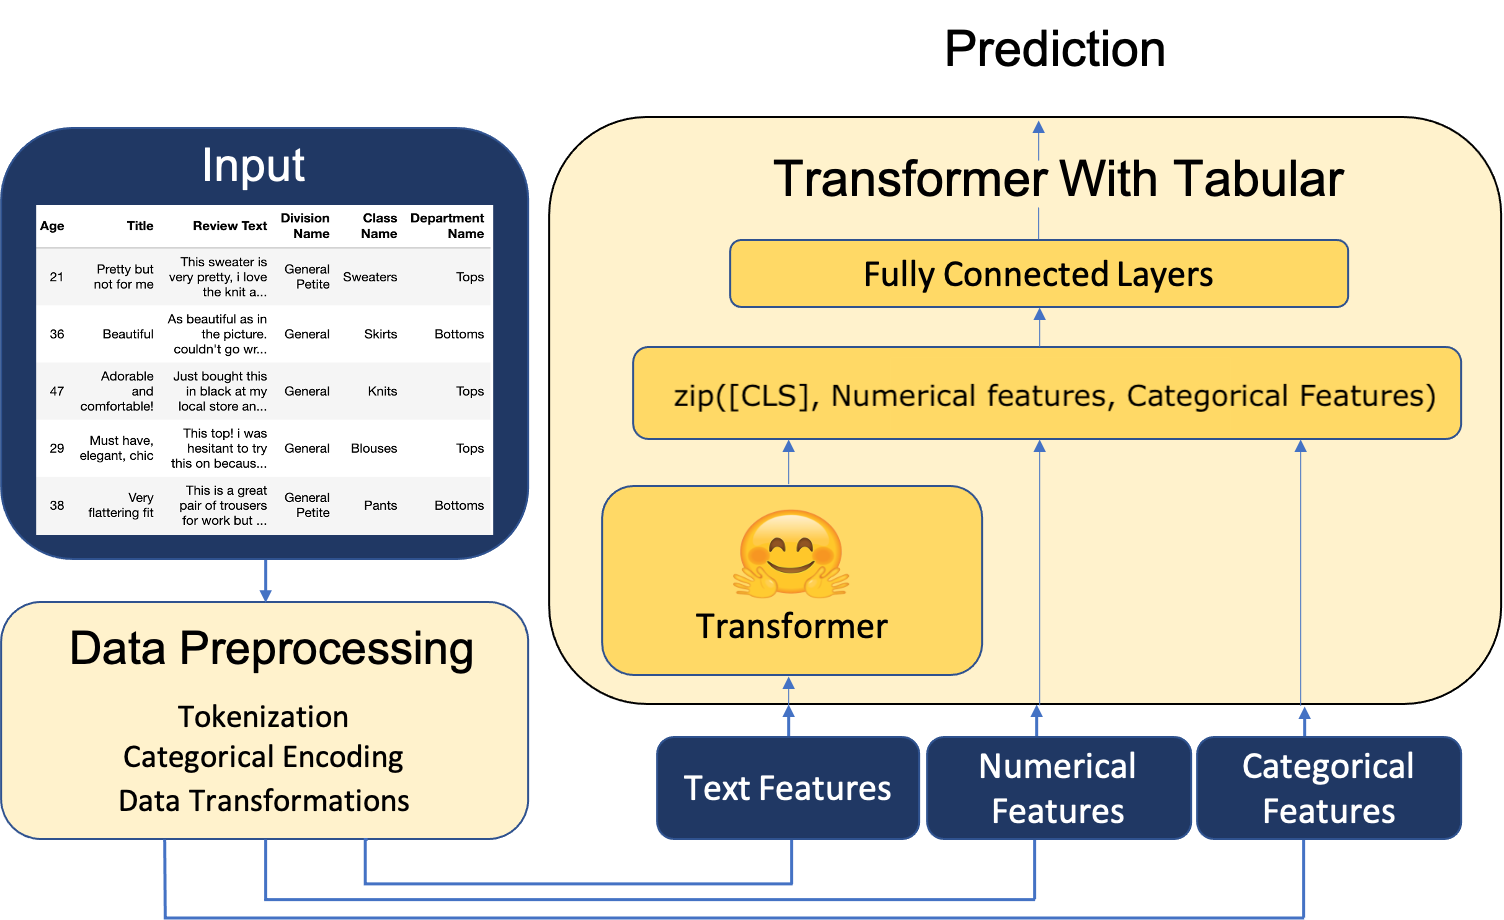

### Preprocessing

In [ ]:
# We change the types of all features to match with the use of a XGboost
train_ef = train_df.copy()
validation_ef = val_df.copy()
test_ef = test_df.copy()

# for each sub dataset we change the reviewer_age in interger and the reviewer_gender and the product_category as a category variable

for df in [train_ef, validation_ef, test_ef]:
  df["reviewer_age"] = df["reviewer_age"].astype('int')
  df["reviewer_gender"] = df["reviewer_gender"].astype('category')
  df["product_category"] = df["product_category"].astype('category')

  df["reviewer_gender"] = df["reviewer_gender"].cat.codes
  df["product_category"] = df["product_category"].cat.codes

tds_ef = Dataset.from_pandas(train_ef)
vds_ef = Dataset.from_pandas(validation_ef)
pds_ef = Dataset.from_pandas(test_ef)

ds_ef = DatasetDict()

ds_ef['train'] = tds_ef
ds_ef['val'] = vds_ef
ds_ef['test'] = pds_ef

for t in ['train', 'val', 'test']:
  new_features = ds_ef[t].features.copy()
  new_features["label"] = ClassLabel(names=["negative", "positive"])
  ds_ef[t] = ds_ef[t].cast(new_features)

Casting the dataset:   0%|          | 0/5 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets_early = ds_ef.map(tokenize,
                                     fn_kwargs={"variable":'text', 'tab_data':True},
                                     batched=True, 
                                     remove_columns=['prediction_ts', 	
                                                     'text',
                                                     'all_text',
                                                     'language',
                                                     '__index_level_0__'
                                                    ])

tokenized_datasets_early = tokenized_datasets_early.rename_column("label", "labels")
tokenized_datasets_early.set_format("torch")

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets_early

DatasetDict({
    train: Dataset({
        features: ['reviewer_age', 'reviewer_gender', 'product_category', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'extra_data'],
        num_rows: 4332
    })
    val: Dataset({
        features: ['reviewer_age', 'reviewer_gender', 'product_category', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'extra_data'],
        num_rows: 537
    })
    test: Dataset({
        features: ['reviewer_age', 'reviewer_gender', 'product_category', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'extra_data'],
        num_rows: 531
    })
})

In [ ]:
from torch import nn
from transformers import AutoConfig, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple


### Model Architecture

We collect the [CLS] token from a BERT model and combine it with the additional numerical and categorical tabular data we have. Then, we train a classifier on the combination.

In [ ]:
# inspired from: https://colab.research.google.com/drive/1F7COnwHqcLDPg_SS-oFgW3c2GPDWnS5Y#scrollTo=KWPYRcKeDPNa
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""
    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, 10)
        
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(10, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)                 # Randomly drops out some of the neurons according to the specified dropout rate (classifier_dropout or config.hidden_dropout_prob)
        x = self.dense(x)                          # Dense (fully connected) layer 
        x = torch.tanh(x)                          # Hyperbolic tangent (tanh) activation function
        x = self.dropout(x)                        # Randomly drops out some of the neurons
        x = self.out_proj(x)                       # Output projection layer
        return x

class BertTabular(BertForSequenceClassification):

    def __init__(self, config, num_extra_dims, Freeze=True):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.bert =  BertModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)
        self.post_init()                          # Initialize weights

        if Freeze:
          for param in self.bert.parameters():
            param.requires_grad = False
    
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        ) -> Union[Tuple, SequenceClassifierOutput]:
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        cls_embedding = outputs[0][:, 0, :]                                     # [CLS] token extracted
        output = torch.cat((cls_embedding, extra_data), dim=-1)                 # tabular data and [CLS] concatenated

        logits = self.classifier(output)

        loss_fct = nn.CrossEntropyLoss()                                        # define our loss: Cross Entropy
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(                                        # return the outputs of our classification mdodel
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
bert_tabular = BertTabular.from_pretrained("bert-base-uncased", num_labels=2, num_extra_dims=3)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

### Training

In [ ]:
args = TrainingArguments(
    output_dir="model_bert_tabular",
    evaluation_strategy=IntervalStrategy.EPOCH,
    save_strategy = IntervalStrategy.EPOCH,
    save_total_limit = 2,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=nb_epochs,
    metric_for_best_model='accuracy',
    load_best_model_at_end=True,
    seed=0,
)

trainer_bert_tabular = Trainer(
    model=bert_tabular,
    args=args,
    train_dataset=tokenized_datasets_early["train"],
    eval_dataset=tokenized_datasets_early["val"],
    compute_metrics=compute_metrics,
    data_collator = data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)]
)

trainer_bert_tabular.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertTabular.forward` and have been ignored: reviewer_gender, reviewer_age, product_category. If reviewer_gender, reviewer_age, product_category are not expected by `BertTabular.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4332
  Num Epochs = 9
  Instantaneous batch 

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.691400,0.688687,0.745182,0.778399
2,0.684500,0.675212,0.866426,0.862197
3,0.670800,0.653769,0.888889,0.880819
4,0.652200,0.631774,0.902309,0.897579
5,0.635200,0.612205,0.908438,0.905028
6,0.616000,0.596920,0.907441,0.905028
7,0.604300,0.585825,0.907441,0.905028
8,0.594200,0.579132,0.907441,0.905028
9,0.588400,0.576877,0.913357,0.910615


The following columns in the evaluation set don't have a corresponding argument in `BertTabular.forward` and have been ignored: reviewer_gender, reviewer_age, product_category. If reviewer_gender, reviewer_age, product_category are not expected by `BertTabular.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 537
  Batch size = 8
Saving model checkpoint to model_bert_tabular/checkpoint-542
Configuration saved in model_bert_tabular/checkpoint-542/config.json
Model weights saved in model_bert_tabular/checkpoint-542/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertTabular.forward` and have been ignored: reviewer_gender, reviewer_age, product_category. If reviewer_gender, reviewer_age, product_category are not expected by `BertTabular.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 537
  Batch size = 8
Saving model checkpoint to model_bert_tab

TrainOutput(global_step=4878, training_loss=0.6333686669081047, metrics={'train_runtime': 353.4639, 'train_samples_per_second': 110.303, 'train_steps_per_second': 13.801, 'total_flos': 2564729221625856.0, 'train_loss': 0.6333686669081047, 'epoch': 9.0})

### Prediction

In [ ]:
predictions = trainer_bert_tabular.predict(tokenized_datasets_early["test"])
new_result = {'Model': 'BertTabular', 'F1': predictions.metrics['test_f1'], 'Accuracy': predictions.metrics['test_accuracy']}
df2 = pd.DataFrame([new_result])
df_result = pd.concat([df_result, df2], ignore_index=True)
df_result

The following columns in the test set don't have a corresponding argument in `BertTabular.forward` and have been ignored: reviewer_gender, reviewer_age, product_category. If reviewer_gender, reviewer_age, product_category are not expected by `BertTabular.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 531
  Batch size = 8


,Model,F1,Accuracy
0,XGBoost,0.583026,0.574388
1,BERT_review_only,0.805508,0.787194
2,Bert_all_text,0.820976,0.813559
3,BertTabular,0.929104,0.928437


# Conclusion

Based on the results presented in the table, we can see that each new model outperforms our metric objectives. Even though the results of the XGBoost model may suggest that tabular data is not relevant for our problem, the two multimodal models show that incorporating the tabular data with the textual data improves our metrics. Compared to the Bert_review_only model fine-tuned on the review variable only, we see an improvement of approximately 2% in the F1 score and accuracy with the Bert_all_text model, and an improvement of approximately 14% with the BertTabular model. The BertTabular model appears to have the best performance in terms of both F1 score and accuracy. 
It should be noted that we did not perform a grid search for the hyperparameters of the XGBoost model, and didn't find the best hyperparameters for the three BERT-based models. We could have also continued the training for each BERT-based model based on the continuous decrease of the training/validation loss or incorporated more data from the original dataset, but our goal was to demonstrate techniques rather than achieving robust results.

It would be beneficial to apply this techniques with your data. 
With this code, you may be able to quickly implement your model. I hope this helps.

## Future Work

In a future work, the following options and methods can be considered:

1. Work with different outputs: you could try to compute metrics over the outputs of the two models you previously used (Xgboost and a Transformer) as a Late fusion model.

2. Experiment with different architectures: You could try incorporating other transformer-based models and compare their performance to the models you used in your current study (or compare to our Bert model).

3. Handling missing data: Tabular data can contains missing values, you could explore different methods for handling missing data, such as imputation or using models that are robust to missing data, and see how they affect the performance of your models.
In our case example, we did not have the opportunity to face the problem.

4. Incorporating additional data sources: You could try incorporating additional data sources, in addition to tabular and text data, and see if it improves performance.

5. Explore alternative architecture: for example Multimodal-Toolkit (https://github.com/georgian-io/Multimodal-Toolkit) which is a framework for integrating tabular data with textual data for performing classification and regression tasks, utilizing the HuggingFace transformers library as the foundation for extracting text features.


***Research**

1. Incorporating attention mechanisms: You could experiment with incorporating an alternativ attention mechanisms in your models to see if it improves performance.


These are just a few ideas, and you may find other interesting directions to pursue based on the specific details of your work. I encourage you to discuss with us and read related works, I can provide, in order to have a deeper understanding of the field.